In [1]:
from dotenv import load_dotenv

# Environment variables are set for gene-normalizer dynamodb instance and
# UTA DB credentials. This needs to be the first cell since variation.main
# creates an instance of QueryHandler
load_dotenv()

True

In [2]:
import gzip  # noqa: E402
import json  # noqa: E402
import os  # noqa: E402

import numpy as np  # noqa: E402
import pandas as pd  # noqa: E402
import plotly.graph_objects as go  # noqa: E402
from cool_seq_tool.schemas import ResidueMode  # noqa: E402
from tqdm.notebook import tqdm  # noqa: E402
from variation.main import get_feature_overlap  # noqa: E402
from IPython.display import Image  # noqa: E402

/Users/kxk102/Documents/genomic_med_lab/variation-normalizer-manuscript/.venv/lib/python3.11/site-packages/python_jsonschema_objects/__init__.py:46: UserWarning: Schema version http://json-schema.org/draft-07/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


***Using Gene Database Endpoint: http://localhost:8000***


In [3]:
pd.set_option("display.max_columns", 100)

# Load data sets

## NCH array results (queries)

In [4]:
df = pd.read_csv("cnv_data/NCH-microarray-CNVs-cleaned.csv")
df = df[
    df["start_38"].notna() & df["stop_38"].notna()
].copy()  # restrict to variants with valid GRCh38 start and stop positions

print("Rows:", len(df))
df.head()

Rows: 8685


,variant,build,chromosome,start,stop,start_38,stop_38,copy_number,copy_number_min,copy_number_max
0,7q35(146581450_146661741)x3,GRCh37,7,146581450,146661741,146884357,146964649,3,3,3
1,22q11.21q11.23(21798705_23751189)x3,GRCh37,22,21798705,23751189,21444415,23409002,3,3,3
2,18p11.32(146484_408044)x1,GRCh37,18,146484,408044,146483,408044,1,1,1
3,3q25.1(150353937_150944378)x1,GRCh37,3,150353937,150944378,150636149,151226590,1,1,1
4,16p12.1(27864452_27995317)x3,GRCh37,16,27864452,27995317,27853130,27983996,3,3,3


## ClinVar CNVs (search space)

In [5]:
dv = pd.read_csv("cnv_data/ClinVar-CNVs-normalized.csv")
print("Rows:", len(dv))
dv.head()

Rows: 79330


,id,name,variation_type,assembly,chr,start_38,stop_38,absolute_copies,min_copies,max_copies
0,1676567,NM_005445.4(SMC3):c.1343dup (p.Glu449fs),Duplication,NaN,NaN,110589641,110589642,NaN,NaN,NaN
1,29615,NC_000014.9:g.(53815591_53825260)_(53983697_53...,Deletion,NaN,NaN,53825259,53983698,NaN,NaN,NaN
2,1340493,GRCh37/hg19 12p12.3(chr12:17595624-18236175)x3,copy number gain,GRCh37,12,17442689,18083241,3.0,NaN,NaN
3,1340674,GRCh37/hg19 7q31.33-32.1(chr7:127050634-127826...,copy number gain,GRCh37,7,127410579,128186178,3.0,NaN,NaN
4,814630,GRCh37/hg19 4q33-34.1(chr4:171505226-173149981)x3,copy number gain,GRCh37,4,170584074,172228830,3.0,NaN,NaN


# Get Overlap of NCH and ClinVar Variants with Protein-Coding Regions (CDS) 
Use cool-seq-tool ```feature_overlap``` endpoint exposed in Variation Normalizer API

In [6]:
nch_variant_to_overlap = dict()

for ix, var in tqdm(df.iterrows(), total=len(df)):
    query = var["variant"]
    start = var["start_38"]
    end = var["stop_38"]
    chrom = var["chromosome"]

    resp = json.loads(
        get_feature_overlap(
            start=start,
            end=end,
            chromosome=chrom,
            residue_mode=ResidueMode.INTER_RESIDUE,
        ).json()
    )
    feature_overlap = resp.get("feature_overlap")

    if feature_overlap is not None:
        nch_variant_to_overlap[query] = resp
    else:
        nch_variant_to_overlap[query] = dict()

  0%|          | 0/8685 [00:00<?, ?it/s]

In [7]:
with open("cnv_data/nch_variant_to_overlap.json", "w") as f:
    json.dump(nch_variant_to_overlap, f)

In [8]:
clinvar_id_to_overlap = dict()

for ix, var in tqdm(dv.iterrows(), total=len(dv)):
    query = var["id"]
    start = var["start_38"]
    end = var["stop_38"]
    chrom = var["chr"]

    resp = json.loads(
        get_feature_overlap(
            start=start,
            end=end,
            chromosome=chrom,
            residue_mode=ResidueMode.INTER_RESIDUE,
        ).json()
    )
    feature_overlap = resp.get("feature_overlap")

    if feature_overlap is not None:
        clinvar_id_to_overlap[query] = resp
    else:
        clinvar_id_to_overlap[query] = dict()

  0%|          | 0/79330 [00:00<?, ?it/s]

In [9]:
with open("cnv_data/clinvar_id_to_overlap.json", "w") as f:
    json.dump(clinvar_id_to_overlap, f)

## Auxiliary functions for operations on CDS overlap intervals

In [10]:
def get_intervals_from_overlap(cds_overlap_dict: dict) -> list:
    """in: feature overlap object
    # out: a list of (start, stop) tuples for the intervals of coding sequence overlap with the given variant"""
    return [
        (
            v["overlap"]["interval"]["start"]["value"],
            v["overlap"]["interval"]["end"]["value"],
        )
        for feature_overlap in cds_overlap_dict["feature_overlap"].values()
        for v in feature_overlap
    ]

In [11]:
def calculate_size_of_intervals(intervals: list) -> int:
    """in: a list of (start,stop) tuples
    out: the number of base pairs included in the union of those intervals"""
    return sum(
        [b - a + 1 for (a, b) in intervals if (a is not None) and (b is not None)]
    )

# Measure Similarity Between NCH and ClinVar Variants

## Calculation of Jaccard similarity measures
* Let $Q$ deote the set of base pairs covered by a given NCH query variant $q$
* Let $S$ denote the set of base pairs between the start and stop positions of a given variant $s$ in the ClinVar search space. 
* Let $\text{Gene}$ and $\text{Coding}$ denote the set of base pairs belonging to any gene or any coding exon, respectively.

Unrestricted Jaccard similarity using base pair overlap between the ranges covered by the query and search variants:
$$\text{Jaccard}(q,s) = \frac{|Q\cap S|}{|Q\cup S|}$$

Gene-restricted Jaccard similarity measure of the commonality between the gene-overlapping parts of the query and search variants:
$$\text{Jaccard}_\text{Gene}(q,s) = \frac{|Q\cap S \cap \text{Gene}|}{|(Q \cup S)\cap \text{Gene}|}$$

Coding-restricted Jaccard similarity measure of the commonality between the coding exon-overlapping parts of the query and search variants:
$$\text{Jaccard}_\text{Coding}(q,s) = \frac{|Q\cap S \cap \text{Coding}|}{|(Q \cup S)\cap \text{Coding}|}$$

### A visual aid for Jaccard similarity

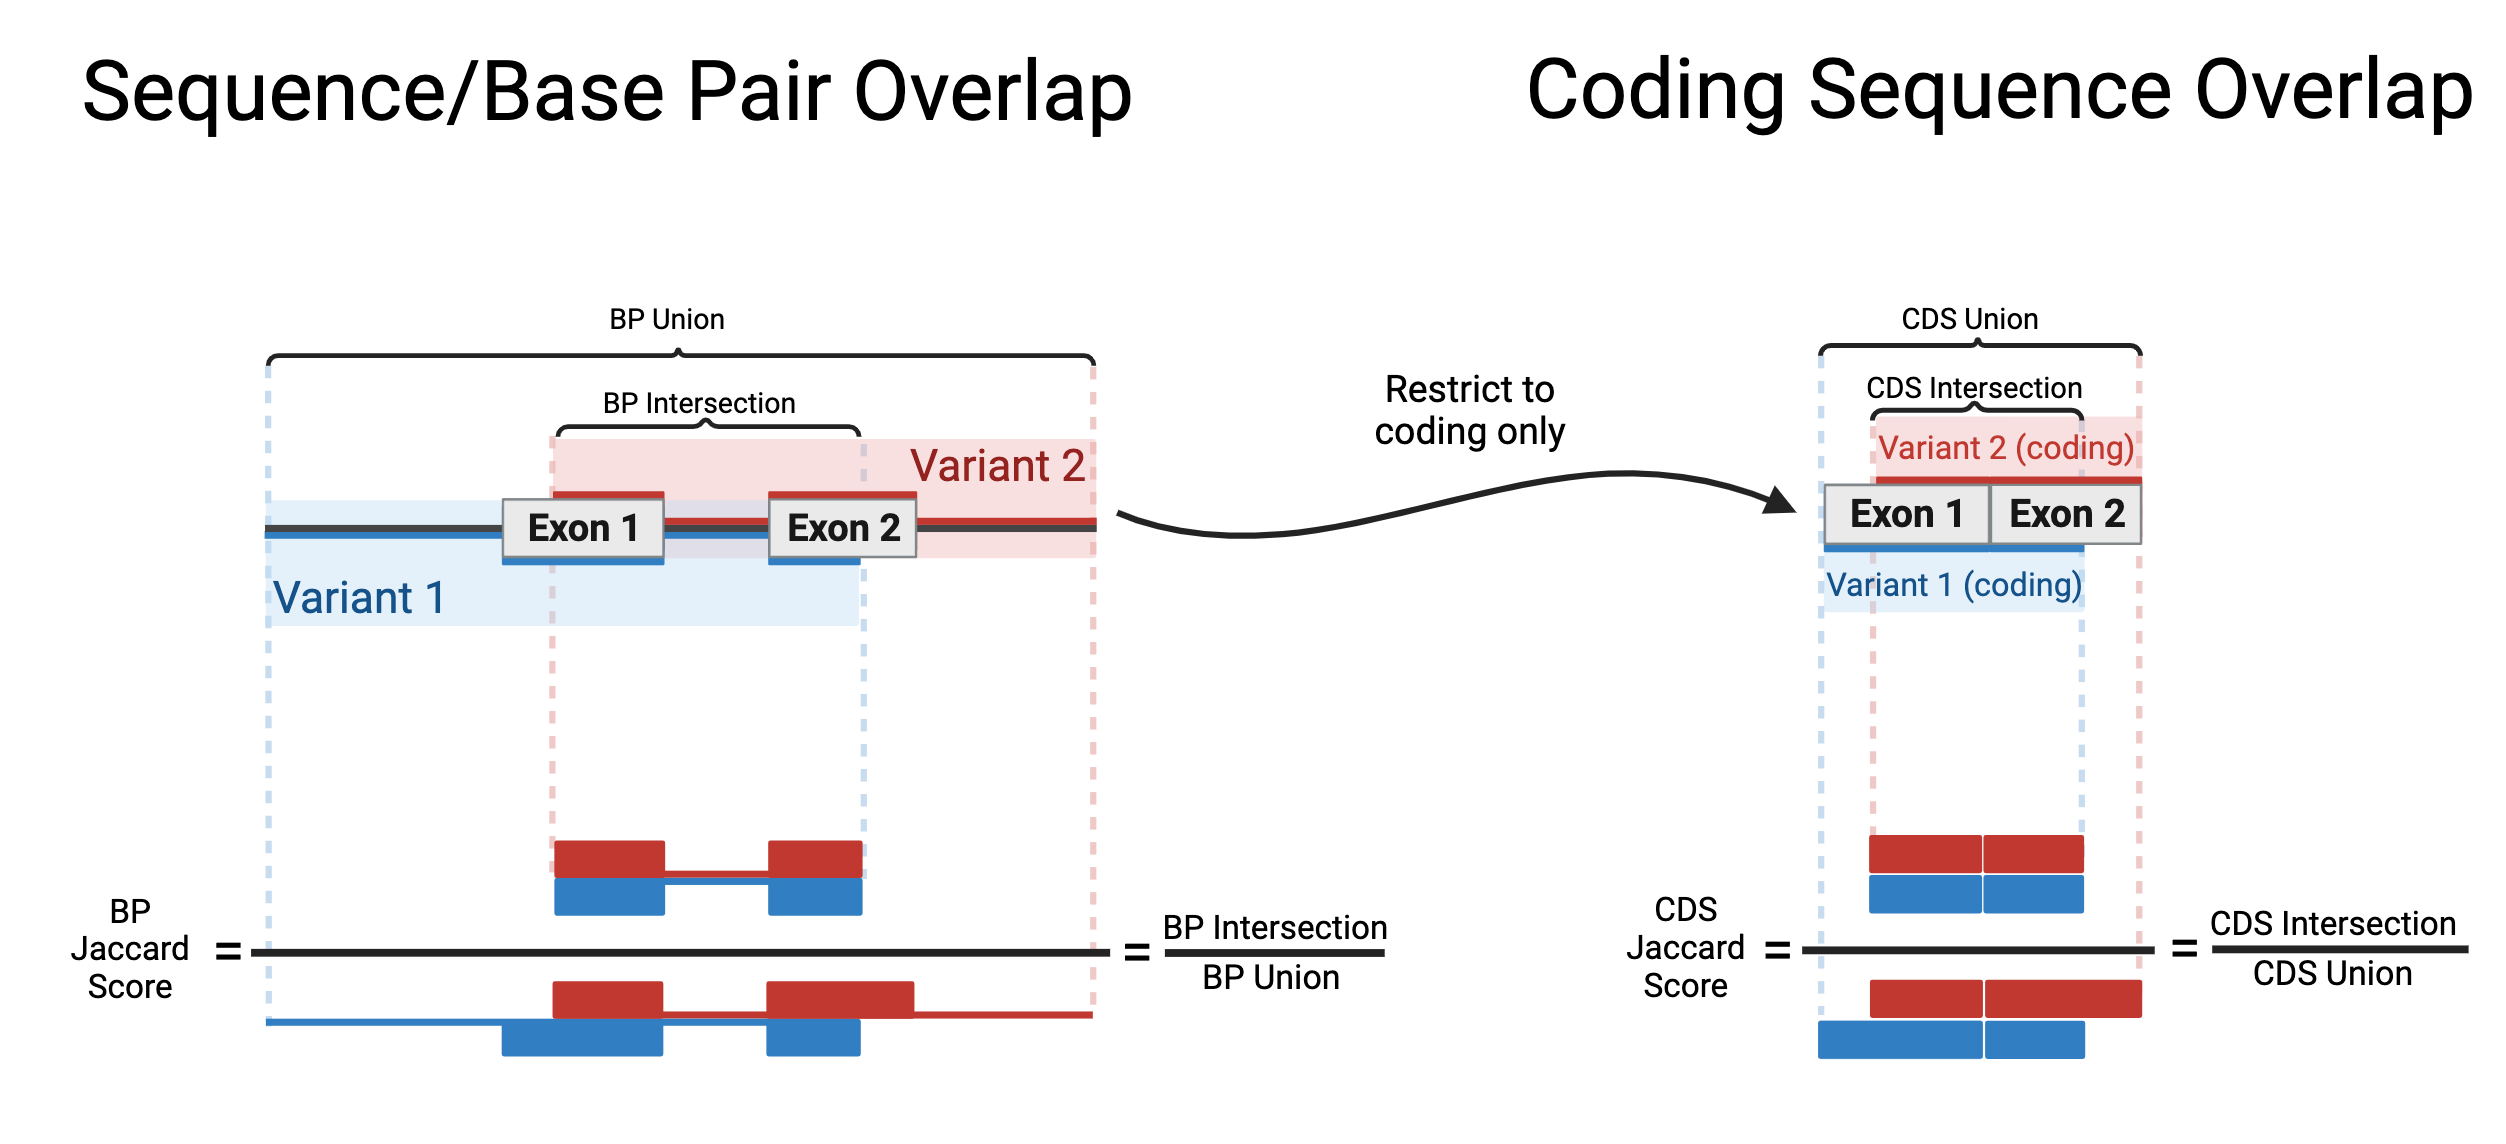

In [12]:
Image("Base Pair and Coding Overlap.png")

### Copy number agreement criteria
So far, we've measured whether CNVs agree solely on the basis of whether they have any base pairs in common; here we also spell out criteria (of increasing strictness) to decide whether they represent the same change in copy number
* <i> Ignore copy number </i> -- only rely on location overlap
* <i> No copy number disagreement </i> -- as long as the copy number information about two variants is not incompatible (and they have location overlap) they can count as a match. Examples:
  * $\text{CNV}_1$ has copy number 3 and $\text{CNV}_2$ has copy number range 3-4; these are not incompatible, so we allow the match
  * $\text{CNV}_1$ has copy number 3 and $\text{CNV}_2$ has no copy number specified (it is a copy number change variant rather than a copy number count); since not enough information is known to deem these incompatible with each other, we allow the match
* <i> Copy number agreement </i> -- we require that copy number agrees between the two variants. Examples:
  * $\text{CNV}_1$ has copy number 3 and $\text{CNV}_2$ has copy number range 3-4; we allow the match
  * $\text{CNV}_1$ has copy number 3 and $\text{CNV}_2$ has no copy number specified; due to missing information, we do not allow the match

## Calculation of Jaccard scores
Here we describe in detail the methods used to calculate each Jaccard score.

<b>For BP Jaccard score</b>: If $\text{CNV}_1$ spans the interval $(a,b)$ and $\text{CNV}_2$ spans the interval $(c,d)$, then they overlap on the intersection of these intervals, that is: $\text{overlap}(\text{CNV}_1,\text{CNV}_2) = (a,b)\cap (c,d)$. Furthermore, in this case it is easy to compute this intersection as $(a,b) \cap (c,d) = (\max(a,c), \min(b,d))$

<b>For CDS Jaccard score</b>: If $\text{CNV}_1$ overlaps coding sequences on the intervals $(a_1,b_1), ..., (a_m,b_m)$ and $\text{CNV}_2$ overlaps coding sequences on the intervals $(c_1,d_1), ... ,(c_n, d_n)$, then their coding sequence-restricted overlap is on the intersection of the unions of these intervals, that is:

$$\text{overlap}_\text{coding}(\text{CNV}_1, \text{CNV}_2) = [(a_1, b_1) \cup \cdots \cup (a_m, b_m)] \cap [(c_1, d_1) \cup \cdots (c_n, d_n)]$$

Calculating this intersection by brute force entails finding the intersection of each $(a_i, b_i)$ with each $(c_j, d_j)$ <i> and </i> accounting for redundancy becomes computationally cumbersome. The functions below implement a procedure for calculating this intersection more efficiently. In essence, the algorithm implemented consists of the following steps:
* We line up all the starts and stops from both collections of intervals in numerical order
* We follow the number line from left to right, tracking whether our current location belongs to either $\text{CNV}_1$ or $\text{CNV}_2$'s coding overlap sets. 
* The stretches for which our current location belongs to both coding overlap sets are appended to the result; after we have scrolled over all of the start and stop points, we will have found the entire intersection set

In [13]:
# the first function weaves the two interval ranges together so the start and stop positions can be read in numerical order,
# tracking which intervals begin and end overlap regions for each variant
def make_interlaced_endpoints(intervals1: list, intervals2: list) -> list:
    """in: two lists of start/stop tuples
    out: a list of position/is_stop/input_number tuples"""
    # auxiliary function for computing operations on lists of intervals
    if not isinstance(intervals1, list):
        intervals1 = []
    if not isinstance(intervals2, list):
        intervals2 = []
    intervals1_tag = [(interval[0], 0, 0) for interval in intervals1] + [
        (interval[-1], 1, 0) for interval in intervals1
    ]
    intervals2_tag = [(interval[0], 0, 1) for interval in intervals2] + [
        (interval[-1], 1, 1) for interval in intervals2
    ]
    return sorted(intervals1_tag + intervals2_tag)

In [14]:
# the second function calculates the intersection of the two
def calculate_intersection_of_overlap_intervals(
    intervals1: list, intervals2: list
) -> list:
    """in: two lists of start/stop tuples
    out: the intersection of both lists of intervals, which is also a list of intervals"""
    interlaced_endpoints = make_interlaced_endpoints(
        intervals1, intervals2
    )  # position/is_stop/input_number
    result_intervals = []
    state, prev_state = 0, 0
    state1, state2 = 0, 0
    a, b = None, None
    for pos, end, inp in interlaced_endpoints:
        state1 = state1 + (
            1 - inp
        )  # does the current position lie in the first range of intervals?
        state2 = (
            state2 + inp
        )  # does the current position lie in the second range of intervals?
        prev_state = state
        state = (
            state1 * state2
        ) % 2  # does the current position belong to both intervals1 AND intervals2?
        if (
            (state - prev_state == 1) & (end == 0)
        ):  # if the state has increased, we've reached part of the intersection; this is an intersection interval start pos
            a = pos
        elif (
            (state - prev_state == -1) & (end == 1)
        ):  # if the state has decreased, we've left part of the intersection; this is an intersection interval stop pos
            b = pos
            result_intervals.append((a, b))
    return result_intervals

In [15]:
def calculate_cds_jaccard(var1_overlap: dict, var2_overlap: dict) -> float:
    """in: CDS overlap objects for two variants
    out: the CDS jaccard similarity score between the two variants"""
    var1_fo = var1_overlap.get("feature_overlap")
    var2_fo = var2_overlap.get("feature_overlap")
    if (var1_fo is None) or (
        var2_fo is None
    ):  # check: both vars have nonzero coding overlap
        return 0
    if (
        len(set(var1_fo) & set(var2_fo)) == 0
    ):  # check:vars overlap on coding regions in the same gene
        return 0
    intervals1 = get_intervals_from_overlap(var1_overlap)
    intervals2 = get_intervals_from_overlap(var2_overlap)

    intersection_size = calculate_size_of_intervals(
        calculate_intersection_of_overlap_intervals(intervals1, intervals2)
    )
    return intersection_size / (
        calculate_size_of_intervals(intervals1)
        + calculate_size_of_intervals(intervals2)
        - intersection_size
    )

### Overlap percentages of individual variants with coding regions
Before matching NCH variants to ClinVar variants, we calculate the overlap fraction of NCH and ClinVar variants with CDS regions.

In [16]:
def calculate_cds_overlap_fraction(start: int, stop: int, overlap_dict: dict) -> float:
    feature_overlap = overlap_dict.get("feature_overlap")
    if feature_overlap is None:
        return 0
    return calculate_size_of_intervals(get_intervals_from_overlap(overlap_dict)) / (
        stop - start + 1
    )


overlap_fraction_values = []
for nch_iscn, start, stop in tqdm(df[["variant", "start_38", "stop_38"]].values):
    overlap_fraction_values.append(
        calculate_cds_overlap_fraction(start, stop, nch_variant_to_overlap[nch_iscn])
    )
df["cds_overlap_fraction"] = overlap_fraction_values

  0%|          | 0/8685 [00:00<?, ?it/s]

In [17]:
overlap_fraction_values = []

for clinvar_id, start, stop in tqdm(dv[["id", "start_38", "stop_38"]].values):
    overlap_fraction_values.append(
        calculate_cds_overlap_fraction(start, stop, clinvar_id_to_overlap[clinvar_id])
    )
dv["cds_overlap_fraction"] = overlap_fraction_values

  0%|          | 0/79330 [00:00<?, ?it/s]

### Matching NCH Variants to ClinVar variants
Here we calculate the matches between NCH and ClinVar
* The dataframe ```dm``` contains all NCH-ClinVar variant pairs with nonzero BP Jaccard similarity score 
* We then calculate the CDS Jaccard score between each of these pairs of variants (nonzero BP Jaccard score is a prerequisite for nonzero CDS Jaccard score, so this is comphrehensive while saving unnecessary searches)
* We consider various thresholds in $[0,1]$ for minimum similarity requirement (Jaccard score > threshold) for both BP and CDS scores (see final figure)

In [18]:
nch_variant_to_matches = dict()

clinvar_cols = dv.columns


for chrom in tqdm(
    sorted(df["chromosome"].unique())
):  # reduce search space by only searching for matches where chromosomes agree
    dv_ = dv[dv["chr"] == chrom].copy()
    df_ = df[df["chromosome"] == chrom].copy()
    for ix, row in df_.iterrows():
        a, b = row["start_38"], row["stop_38"]
        dv_match = dv_[(a <= dv_["stop_38"]) & (b >= dv_["start_38"])].copy()
        dv_match["query_iscn"] = row["variant"]
        dv_match["query_start"] = a
        dv_match["query_stop"] = b
        dv_match["query_copy_number_min"] = row["copy_number_min"]
        dv_match["query_copy_number_max"] = row["copy_number_max"]
        dv_match["query_cds_overlap_fraction"] = row["cds_overlap_fraction"]
        nch_variant_to_matches[row["variant"]] = dv_match.set_index("id").to_dict(
            orient="index"
        )

  0%|          | 0/24 [00:00<?, ?it/s]

In [19]:
# dataframe of all matched pairs found
dm = pd.concat(
    [
        pd.DataFrame().from_dict(data=dvm, orient="index")
        for dvm in tqdm(nch_variant_to_matches.values())
    ]
)
dm.index.name = "clinvar_id"
dm = dm.reset_index()

# code compy number agreement policies
dm["copy_number_agree"] = (dm["absolute_copies"] >= dm["query_copy_number_min"]) & (
    dm["absolute_copies"] <= dm["query_copy_number_max"]
)
dm["copy_number_no_disagree"] = ~(
    dm["absolute_copies"] < dm["query_copy_number_min"]
) & ~(dm["absolute_copies"] > dm["query_copy_number_max"])
dm["copy_number_disagree"] = (dm["absolute_copies"] < dm["query_copy_number_min"]) | (
    dm["absolute_copies"] > dm["query_copy_number_max"]
)


# calculate BP Jaccard similarity score
dm["bp_jaccard"] = (
    dm[["query_start", "start_38"]].max(axis=1)
    - dm[["query_stop", "stop_38"]].min(axis=1)
) / (
    dm[["query_start", "start_38"]].min(axis=1)
    - dm[["query_stop", "stop_38"]].max(axis=1)
)

  0%|          | 0/8685 [00:00<?, ?it/s]

In [20]:
cds_jaccard_values = []
for nch_iscn, clinvar_id in tqdm(dm[["query_iscn", "clinvar_id"]].values):
    cds_jaccard_values.append(
        calculate_cds_jaccard(
            nch_variant_to_overlap[nch_iscn], clinvar_id_to_overlap[clinvar_id]
        )
    )

dm["cds_jaccard"] = cds_jaccard_values

  0%|          | 0/1423554 [00:00<?, ?it/s]

In [21]:
fig = go.Figure()

thrs = list(np.arange(0, 1.001, 0.001))
vals = []

for thr in thrs:
    vals.append(len(df[df["cds_overlap_fraction"] > thr]))
fig.add_trace(
    go.Scatter(
        x=thrs,
        y=vals,
        name="CDS-Intersected",
        marker_color="DarkGreen",
    )
)

fig.update_xaxes(title="Variant Overlap % Threshold", range=[0, 1])
fig.update_yaxes(title="# Variants Meeting Overlap Requirement", range=[0, len(df)])
fig.update_layout(
    title="NCH Query Variant Feature Overlap",
    height=500,
    width=750,
    legend=dict(x=1, xanchor="right", bgcolor="rgba(0,0,0,0)"),
)
fig.show()

In [22]:
fig.write_image("nch-query-variant-feature-overlap.png", "png")

In [23]:
fig = go.Figure()

thrs = list(np.arange(0, 1.01, 0.01))
vals = []

for thr in thrs:
    vals.append(len(dv[dv["cds_overlap_fraction"] > thr]))
fig.add_trace(
    go.Scatter(
        x=thrs,
        y=vals,
        name="CDS-Intersected",
        marker_color="DarkGreen",
    )
)


fig.update_xaxes(title="Variant Overlap Threshold", range=[0, 1])
fig.update_yaxes(title="# Variants Meeting Overlap Requirement", range=[0, len(dv)])
fig.update_layout(
    title="ClinVar CNV Feature Overlap",
    height=500,
    width=750,
    legend=dict(x=1, xanchor="right", bgcolor="rgba(0,0,0,0)"),
)
fig.show()

In [24]:
fig.write_image("clinvar-cnv-feature-overlap.png", "png")

In [25]:
# sanity check: the difference between "no disagreement" and "agreement" is that we allow missing values of copy number to be included in "no disagreement matches"
len(dm[(dm["copy_number_no_disagree"]) & (dm["absolute_copies"].notna())]) == len(
    dm[dm["copy_number_agree"]]
)

True

In [26]:
dm

,clinvar_id,name,variation_type,assembly,chr,start_38,stop_38,absolute_copies,min_copies,max_copies,cds_overlap_fraction,query_iscn,query_start,query_stop,query_copy_number_min,query_copy_number_max,query_cds_overlap_fraction,copy_number_agree,copy_number_no_disagree,copy_number_disagree,bp_jaccard,cds_jaccard
0,612186,GRCh37/hg19 1p36.33(chr1:1130727-1289863)x3,copy number gain,GRCh37,1,1195346,1354483,3.0,NaN,NaN,0.153866,1p36.33p36.32(835601_4465846)x3,900220,4405786,3,3,0.035725,True,True,False,0.045396,0.192008
1,612196,GRCh37/hg19 1p36.33(chr1:1247454-1289835)x3,copy number gain,GRCh37,1,1312073,1354455,3.0,NaN,NaN,0.173253,1p36.33p36.32(835601_4465846)x3,900220,4405786,3,3,0.035725,True,True,False,0.012090,0.058634
2,1328099,GRCh37/hg19 1p36.33-36.32(chr1:753552-4034574)x1,copy number loss,GRCh37,1,818171,3974514,1.0,NaN,NaN,0.039677,1p36.33p36.32(835601_4465846)x3,900220,4405786,3,3,0.035725,False,False,True,0.856919,0.994124
3,253365,GRCh37/hg19 1p36.33(chr1:1309373-2043694)x4,copy number gain,GRCh37,1,1373992,2112255,4.0,NaN,NaN,0.044171,1p36.33p36.32(835601_4465846)x3,900220,4405786,3,3,0.035725,False,False,True,0.210597,0.260390
4,565064,GRCh37/hg19 1p36.32(chr1:2419098-3222541)x3,copy number gain,GRCh37,1,2487658,3305977,3.0,NaN,NaN,0.017826,1p36.33p36.32(835601_4465846)x3,900220,4405786,3,3,0.035725,True,True,False,0.233434,0.116477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423549,253625,GRCh37/hg19 Yp11.32-q12(chrY:10701-59349277)x1,copy number loss,GRCh37,Y,10700,57203126,1.0,NaN,NaN,0.001187,"Yp11.2(7,843,822-8,523,255)x3",7975780,8655214,3,3,0.000000,False,False,True,0.011880,0.000000
1423550,146389,GRCh38/hg38 Yp11.32-q12(chrY:10701-57189762),copy number loss,GRCh38,Y,10700,57189762,NaN,NaN,NaN,0.001187,"Yp11.2(7,843,822-8,523,255)x3",7975780,8655214,3,3,0.000000,False,True,False,0.011883,0.000000
1423551,155352,GRCh38/hg38 Yp11.31-q11.21(chrY:301880-1168002...,copy number gain,GRCh38,Y,301879,11680029,3.0,NaN,NaN,0.001483,"Yp11.2(7,843,822-8,523,255)x3",7975780,8655214,3,3,0.000000,True,True,False,0.059714,0.000000
1423552,144190,GRCh37/hg19 Yp11.31-q12(chrY:2654852-59031480)x3,copy number gain,GRCh37,Y,2786810,56885333,3.0,NaN,NaN,0.001255,"Yp11.2(7,843,822-8,523,255)x3",7975780,8655214,3,3,0.000000,True,True,False,0.012559,0.000000


In [27]:
dm[
    [
        "query_iscn",
        "clinvar_id",
        "copy_number_agree",
        "copy_number_no_disagree",
        "bp_jaccard",
        "cds_jaccard",
    ]
].to_csv(
    os.path.join("cnv_data", "match-scoring-results.csv.gz"),
    compression="gzip",
    index=False,
)

In [28]:
with gzip.open(os.path.join("cnv_data", "match-scoring-results.csv.gz"), "rb") as f:
    dm_min = pd.read_csv(f)

## Visualizing matching criteria with varying match score threshold

In [29]:
def jaccard_matching_figure(
    match_data: pd.core.frame.DataFrame,
    title="Matching with Varying Similarity Threshold",
    subtitle=None,
    step=0.001,
):
    thrs = list(np.arange(0, 1 + step, step))

    fig = go.Figure()

    measures = [c for c in match_data.columns if "jaccard" in c]
    colors = ["Black", "goldenrod"]
    for measure, color in zip(measures, colors):
        values1 = []
        values2 = []
        values3 = []
        for thr in tqdm(thrs):
            if thr == 1:  # score max is 1
                dm_ = match_data[match_data[measure] >= thr].copy()
            else:
                dm_ = match_data[match_data[measure] > thr].copy()
            values1.append(dm_["query_iscn"].nunique())
            values2.append(dm_[dm_["copy_number_no_disagree"]]["query_iscn"].nunique())
            values3.append(dm_[dm_["copy_number_agree"]]["query_iscn"].nunique())

        name_pfx = f"{measure.split('_')[-1].title()}".replace(
            "Jaccard", "Base Pair Range"
        )
        fig.add_trace(
            go.Scatter(
                x=thrs,
                y=values1,
                marker_color=color,
                line_dash="dot",
                name=f"{name_pfx} - CN Ignored",
                legendgroup="ignore",
            )
        )
        fig.add_trace(
            go.Scatter(
                x=thrs,
                y=values2,
                marker_color=color,
                line_dash="dash",
                name=f"{name_pfx} - No CN Disagreement",
                legendgroup="lax",
            )
        )
        fig.add_trace(
            go.Scatter(
                x=thrs,
                y=values3,
                marker_color=color,
                line_dash="solid",
                name=f"{name_pfx} - CN Agreement",
                legendgroup="strict",
            )
        )

    fig.update_xaxes(
        title="Jaccard Similarity Threshold", linecolor="black", title_font_size=20
    )
    fig.update_yaxes(
        title="# Variants with ≥1 Match",
        linecolor="black",
        title_font_size=20,
        gridcolor="lightgray",
    )
    if subtitle:
        title = f"{title}<br>{subtitle}"
    fig.update_layout(
        title=title,
        title_font_size=24,
        title_x=0.5,
        height=750,
        width=1000,
        plot_bgcolor="white",
        #        legend_bgcolor="rgba(0,0,0,0)",
        legend=dict(x=1, xanchor="right"),
    )

    for tr in fig.data:
        name = tr.name
        if "Cds" in name:
            fig.update_traces(
                selector=dict(name=name), name=name.replace("Cds", "Coding Exon")
            )

    return fig

## Matching to full search space

In [30]:
fig = jaccard_matching_figure(dm)
fig.show()

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

In [31]:
fig.write_image("matching-with-varying-similarity-threshold.png", "png")

### Figure: Jaccard similarity matching between NCH and ClinVar Variants with varying match score threshold
The horizontal axis represents minimum allowed Jaccard score required for a match; the vertical axis then measures the number of query variants (NCH variants) which have a match under the corresponding matching policy. The different texture of lines correspond to different copy number matching policies ("ignore copy number", "no copy number disagreement", and "copy number agreement").

The different color curves represent the different Jaccard overlap scores:
* Black: base pair/location overlap (the most elementary, merely relies on the start and stop positions of the query variant and candidate match variant)
* Green: coding sequence (CDS) overlap

Points near the far left represent matching policies that are very lax; variants are considered a match as long as they have nonzero overlap on the given feature. The right end, requiring Jaccard score of 1, is the strictest possible, meaning that the variants must span the exact same base pair range (or overlap with exactly the same locations on genes or in coding sequences)